In [12]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

##PARAMETERS
EXP_NAME = 'Proxy'
MAX_ROUNDS = 699
MAX_YVAL = 14
# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/test/',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/test/',EXP_NAME)

##SET SEABORN STYLE
sns.set_style("whitegrid")
sns.set_context("paper")

##SET MATPLOTLIB STYLE
TICKS_FONTSIZE = 16
LABEL_FONTSIZE=18
LEGEND_FONTSIZE=15

mpl.rcParams['xtick.labelsize'] = TICKS_FONTSIZE 
mpl.rcParams['ytick.labelsize'] = TICKS_FONTSIZE
mpl.rcParams['legend.fontsize'] = TICKS_FONTSIZE
mpl.rcParams['axes.labelsize'] = LABEL_FONTSIZE
mpl.rcParams['axes.titlesize'] = LABEL_FONTSIZE
mpl.rcParams['font.size'] = LABEL_FONTSIZE
plt.rc('legend',**{'fontsize':LEGEND_FONTSIZE})


######################### BASIC FUNCTIONS  ###########################
#######################################################################

linestyles = (':','-')
def read_results():
	"""Reads the results for all the nodes and returns
	a list of pandas Dataframes, one for each node"""
	#Get list of nodes(files) with results
	nodes = [f for f in os.listdir(RESULTS_DIR) if os.path.isfile(os.path.join(RESULTS_DIR, f))]
	#Load results from each node
	nodes_results = {}
	for node in nodes:
		f = os.path.join(RESULTS_DIR,node)
		try:
			nodes_results[node] = pd.read_csv(f)
			nodes_results[node] = nodes_results[node].replace('None',np.nan)
		except Exception:
			print('EXception')
	return nodes_results

def plot_var_per_round(results, var):
	"""Plot the median acrros nodes of a variable"""
	median = getMedianDF(results,var)
	#Create new figure
	fig = plt.figure()
	#Print the plot
	median.plot()
	#Modify parameters
	plt.ylabel(var)
	plt.xlabel('rounds')
	plt.xlim(0,MAX_ROUNDS)
	plt.ylim(0,MAX_YVAL)
	#Dummy line to avoid bug of matplotlib that closes image right after plot
	#It's a readline function, just press enter
	#input('Done')
	#You can also automatically save figures
	#fig.savefig(os.path.join(GRAPHS_DIR,var.replace(' ','_')+'_per_round.png'), format='png', dpi=fig.dpi)
	

def plot_var_ecdf_per_round(results, var):
	"""Plot the ECDF of the median accross the nodes of a variable"""
	lbl = []
	for v in var:
		median = getMedianDF(results,v)
		ecdf = getECDF(median)
		ecdf.plot()
		lbl.append(v)
	plt.ylabel('ECDF')
	plt.legend(lbl, loc = 'lower right')
	plt.xlim(0,MAX_YVAL)
	plt.show()
	#input('Done')

def plot_comparative(results,variables, legend):
	
	# Get median time series for all varibales
	medians = [getMedianDF(results,var) for var in variables]
	i=0
	colors = ['red', 'blue']
	lbl=[]
	for median in medians:
		median.plot(label = legend[i], linewidth=2.0, linestyle=linestyles[i], color=colors[i])
		lbl.append(legend[i])
		i+=1
	plt.legend(variables)
	plt.ylabel(legend)
	plt.xlim(0,MAX_ROUNDS)
	plt.ylim(0,MAX_YVAL)
	plt.show()
    
def plot_comparative_ecdf(results1,results2, var):
	"""Plot the ECDF of the median accross the nodes of a variable"""
	lbl = []
	median1 = getMedianDF(results1,var)
	median2 = getMedianDF(results2,var)
	ecdf1 = getECDF(median1)
	ecdf2 = getECDF(median2)
	ecdf1.plot(label='UDP error', legend=True, linewidth=2.0, color='red')
	ecdf2.plot(label='HTTP error', linewidth=2.0, color='blue')
	plt.ylabel('ECDF')
	lbl.append('UDP error')
	lbl.append('HTTP error')
	plt.legend(lbl, loc = 'lower right')
	plt.xlim(0,MAX_YVAL)
	plt.show()
	#input('Done')
    
def read_results1():
	"""Reads the results for all the nodes and returns
	a list of pandas Dataframes, one for each node"""
	#Get list of nodes(files) with results
	nodes = [f for f in os.listdir(RESULTS_DIR1) if os.path.isfile(os.path.join(RESULTS_DIR1, f))]
	#Load results from each node
	nodes_results = {}
	for node in nodes:
		f = os.path.join(RESULTS_DIR1,node)
		try:
			nodes_results[node] = pd.read_csv(f)
			nodes_results[node] = nodes_results[node].replace('None',np.nan)
		except Exception:
			print('EXception')
	return nodes_results

def plot_comparative_dataframes(results1,results2, variable):
	# Get median time series for all varibales
	lbl = []
	colors = ['blue', 'red']
	medians = [getMedianDF(results1,variable), getMedianDF(results2, variable)]
	medians[0].rename('Client error')
	medians[1].rename('Proxy error')
	i=0
	for median in medians:
		median.plot(linewidth=2.0, linestyle=linestyles[i], color=colors[i])
		i+=1
	lbl.append('Client error')
	lbl.append('Proxy error')
	plt.ylabel('Error (s)')
	plt.legend(lbl, loc = 'upper right')
	plt.xlim(0,MAX_ROUNDS)
	plt.ylim(0,MAX_YVAL)
	plt.show()


############################### HELPERS  ##############################
#######################################################################

def getMedianDF(nodes_results,var):
	""""Helper function that extracts median time series of the var
	accross the various nodes"""
	series = []
	total=0
	count=0
	for name,r in nodes_results.items():
		#Normalize duplicate rounds
		r['round'] = r['round'].apply(np.trunc)
		s = r.groupby('round',axis=0).mean()[var]
		total+=s.mean()
		count+=1
		s.name = name
		series.append(s)
	#try:
	#print(series)
	df = pd.concat(series,axis=1)
	#except:
		#ipdb.set_trace()
	median = df.median(axis=1)
	median.name = var
	return median



def getECDF(df):
	"""Helper function that caclulates the ECDF of a
	dataframe"""
	df = df.sort_values().value_counts()
	ecdf = df.sort_index().cumsum()*1./df.sum()
	return ecdf



In [4]:
##PARAMETERS
EXP_NAME = 'c2c'
MAX_ROUNDS = 600
MAX_YVAL = 1
# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/broad_test/HTTP',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/broad_test/HTTP',EXP_NAME)



if __name__ == '__main__':
	nodes_results = read_results()
	#plot_var_per_round(nodes_results,'rtt')
	#plot_var_ecdf_per_round(nodes_results,['AVG RTT', 'AVG distance'])
	#plot_comparative(nodes_results,['rtt', 'distance'], 'Latency (s)')


1.1550354513126126
1.3443102490518761


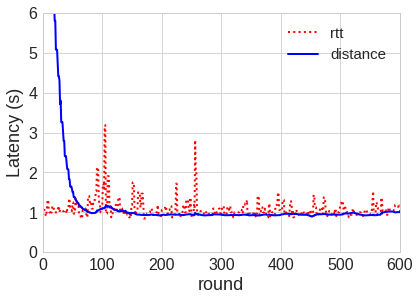

In [22]:
##PARAMETERS
EXP_NAME = 'c2p'
MAX_ROUNDS = 600
MAX_YVAL = 6
# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/broad_test/random',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/broad_test/random',EXP_NAME)


if __name__ == '__main__':
	nodes_results = read_results()
	#plot_var_per_round(nodes_results,'rtt')
	#plot_var_ecdf_per_round(nodes_results,['AVG RTT', 'AVG distance'])
	plot_comparative(nodes_results,['rtt', 'distance'], 'Latency (s)')

0.02759285392104227
0.9271099663927828


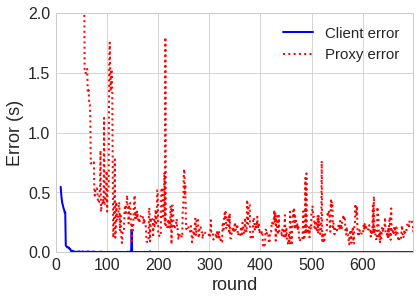

In [49]:
##PARAMETERS
EXP_NAME = 'c'
EXP_NAME1 = 'p'
MAX_ROUNDS = 699
MAX_YVAL = 2
# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/broad_test/HTTP/errors',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/broad_test/HTTP/errors',EXP_NAME)

RESULTS_DIR1 = os.path.join( os.getcwd(),'results/broad_test/HTTP/errors',EXP_NAME1)
GRAPHS_DIR1 = os.path.join( os.getcwd(), 'graphs/broad_test/HTTP/errors',EXP_NAME1)




if __name__ == '__main__':
	nodes_results = read_results()
	nodes_results1 = read_results1()
	plot_comparative_dataframes(nodes_results,nodes_results1, 'error')

9.66964704367523
9.56710504185016


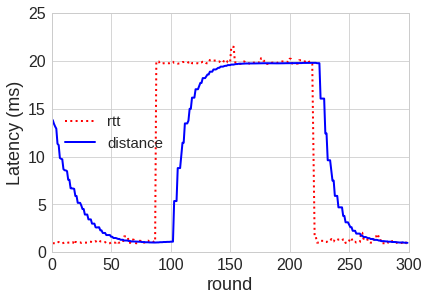

In [3]:
##PARAMETERS
EXP_NAME = 'change'
MAX_ROUNDS = 300
MAX_YVAL = 25
# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/broad_test/random',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/broad_test/random',EXP_NAME)


if __name__ == '__main__':
	nodes_results = read_results()
	#plot_var_per_round(nodes_results,'rtt')
	#plot_var_ecdf_per_round(nodes_results,['AVG RTT', 'AVG distance'])
	plot_comparative(nodes_results,['rtt', 'distance'], 'Latency (ms)')

13.358648235867504
13.13470482204395


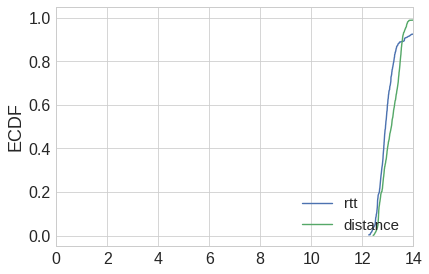

In [3]:
##PARAMETERS
EXP_NAME = 'udp'
EXP_NAME1 = 'http'
MAX_ROUNDS = 699
MAX_YVAL = 14

# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/errors',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/errors',EXP_NAME)

RESULTS_DIR1 = os.path.join( os.getcwd(),'results/errors',EXP_NAME1)
GRAPHS_DIR1 = os.path.join( os.getcwd(), 'graphs/errors',EXP_NAME1)

if __name__ == '__main__':
	nodes_results = read_results()
	#plot_var_per_round(nodes_results,'rtt')
	nodes_results1 = read_results1()    
	plot_var_ecdf_per_round(nodes_results,['rtt', 'distance'])
	#plot_comparative_dataframes(nodes_results,nodes_results1, 'error')

round
3.0      1.406996
4.0      1.065446
5.0      0.797904
6.0      1.025522
7.0      1.460508
8.0      1.442423
9.0      1.698355
10.0     1.299029
11.0     1.482864
12.0     1.028011
13.0     0.848684
14.0     0.927104
15.0     0.913076
16.0     0.878811
17.0     1.038824
18.0     0.894177
19.0     0.518025
20.0     0.872638
21.0     0.547825
22.0     0.413194
23.0     0.317517
24.0     0.398689
25.0     0.476995
26.0     0.486413
27.0     0.551807
28.0     0.551375
29.0     0.476677
30.0     0.277107
31.0     0.328719
32.0     0.446923
           ...   
953.0    2.539386
954.0    2.380405
955.0    2.405353
956.0    2.419648
957.0    2.255286
958.0    2.256062
959.0    2.303743
960.0    2.661460
961.0    2.661009
962.0    2.709310
963.0    1.934628
964.0    1.935815
965.0    1.952907
966.0    2.389738
967.0    2.392939
968.0    2.343023
969.0    2.221878
970.0    2.230855
971.0    2.223860
972.0    3.979622
973.0    3.983634
974.0    4.985412
975.0    3.353349
976.0    3.386443
977.

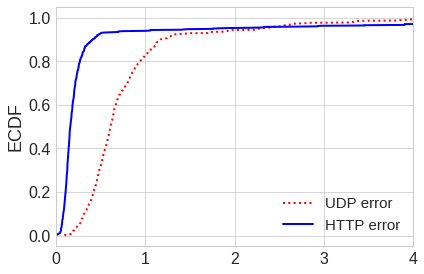

In [13]:
##PARAMETERS
EXP_NAME = 'udp'
EXP_NAME1 = 'http'
MAX_ROUNDS = 699
MAX_YVAL = 4
# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/errors',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/errors',EXP_NAME)

RESULTS_DIR1 = os.path.join( os.getcwd(),'results/errors',EXP_NAME1)
GRAPHS_DIR1 = os.path.join( os.getcwd(), 'graphs/errors',EXP_NAME1)

def plot_comparative_ecdf(results1,results2, var):
	"""Plot the ECDF of the median accross the nodes of a variable"""
	lbl = []
	median1 = getMedianDF(results1,var)
	median2 = getMedianDF(results2,var)
	print(median1)
	ecdf1 = getECDF(median1)
	ecdf2 = getECDF(median2)
	#print(ecdf2)
	ecdf1.plot(label='UDP error', linestyle=linestyles[0], legend=True, linewidth=2.0, color='red')
	ecdf2.plot(label='HTTP error',  linestyle=linestyles[1], linewidth=2.0, color='blue')
	plt.ylabel('ECDF')
	lbl.append('UDP error')
	lbl.append('HTTP error')
	plt.legend(lbl, loc = 'lower right')
	plt.xlim(0,MAX_YVAL)
	plt.show()
	#input('Done')

    
if __name__ == '__main__':
	nodes_results = read_results()
	nodes_results1 = read_results1()    
	plot_comparative_ecdf(nodes_results,nodes_results1, 'error')


Total 0.2866342545724823
Total 0.03870105965622653
COMING HERE


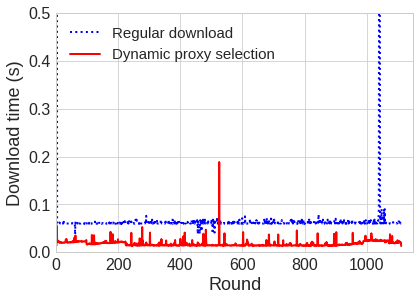

In [18]:
##PARAMETERS
EXP_NAME = 'regular'
EXP_NAME1 = 'random/download'
EXP_NAME2 = 'download'
MAX_ROUNDS = 1150
MAX_YVAL = 0.5
# DEFINE OUTPUT DIR
RESULTS_DIR = os.path.join( os.getcwd(),'results/broad_test/',EXP_NAME)
GRAPHS_DIR = os.path.join( os.getcwd(), 'graphs/broad_test/',EXP_NAME)

RESULTS_DIR1 = os.path.join( os.getcwd(),'results/broad_test/',EXP_NAME1)
GRAPHS_DIR1 = os.path.join( os.getcwd(), 'graphs/errors',EXP_NAME1)

RESULTS_DIR2 = os.path.join( os.getcwd(),'results/broad_test/random/',EXP_NAME2)
GRAPHS_DIR2 = os.path.join( os.getcwd(), 'graphs/errors',EXP_NAME2)

def read_results(results):
	"""Reads the results for all the nodes and returns
	a list of pandas Dataframes, one for each node"""
	#Get list of nodes(files) with results
	main_nodes_results= []
	for result in results:
		nodes = [f for f in os.listdir(result) if os.path.isfile(os.path.join(result, f))]
		#Load results from each node
		nodes_results = {}
		for node in nodes:
			f = os.path.join(result,node)
			nodes_results[node] = pd.read_csv(f)
			nodes_results[node] = nodes_results[node].replace('None',np.nan)
		main_nodes_results.append(nodes_results)
	return main_nodes_results

def getMedianDF(nodes_results,var):
	""""Helper function that extracts median time series of the var
	accross the various nodes"""
	series = []
	total=0
	count=0
	for name,r in nodes_results.items():
		#Normalize duplicate rounds
		r['time'] = r['time'].apply(np.trunc)
		s = r.groupby('time',axis=0).mean()[var]
		total+=s.mean()
		count+=1
		s.name = name
		series.append(s)
	#try:
	df = pd.concat(series,axis=1)
	#except:
		#ipdb.set_trace()
	median = df.median(axis=1)
	median.name = var
	print('Total',total/count)
	return median


def plot_comparative_dataframes(results, variable):
	# Get median time series for all varibales
	lbl = []
	medians = []
	colors = ['blue', 'red']
	for result in results:
		medians.append(getMedianDF(result,variable))
	i=0
	for median in medians:
		median.plot(linewidth=2.0, linestyle=linestyles[i], color=colors[i])
		i+=1
	plt.ylabel('Download time (s)')
	plt.xlabel('Round')
	lbl.append('Regular download')
	#lbl.append('Random proxy selection')
	lbl.append('Dynamic proxy selection')
	plt.legend(lbl, loc = 'best')
	plt.xlim(0,MAX_ROUNDS)
	plt.ylim(0,MAX_YVAL)
	plt.show()
	#input('Done')
    
if __name__ == '__main__':
	nodes_results = read_results([RESULTS_DIR, RESULTS_DIR2])
	plot_comparative_dataframes(nodes_results,'speed_download')

In [16]:
from matplotlib import lines
lines.lineStyles.keys()

dict_keys(['-', '--', '-.', ':', 'None', ' ', ''])